# 1. Librerias 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import fabio
import re
import os
import cv2
import matplotlib.colors

from collections import defaultdict
from celluloid import Camera
from matplotlib.ticker import LogFormatter
from matplotlib import ticker, cm
from tifffile import imread
from scipy.ndimage import zoom
from scipy.signal import fftconvolve
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from pandas import Series, DataFrame
from numpy import nan as NA
from mpl_toolkits.mplot3d import Axes3D
from skimage.segmentation import morphological_chan_vese, morphological_geodesic_active_contour, inverse_gaussian_gradient, checkerboard_level_set

from skimage.transform import resize
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.restoration import richardson_lucy, unsupervised_wiener
#from pylira import LIRADeconvolver

# 2. Funciones

In [2]:
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """
    if not isinstance(lst, list):
        raise TypeError("El argumento debe ser una lista")
    
    def _store(x):
        lst.append(np.copy(x))
    
    return _store

def extraer_kernel(h3, tamano_kernel):
    """
    Extrae un kernel centrado en el punto de máxima intensidad de h3.
    
    Parámetros:
        h3: Matriz 2D (imagen del haz)
        tamano_kernel: Tamaño deseado del kernel (impar recomendado)
        
    Retorna:
        Kernel normalizado y recortado
    """
    if tamano_kernel % 2 == 0:
        raise ValueError("El tamaño del kernel debería ser impar")
    
    # Encuentra el primer máximo (en caso de múltiples máximos)
    centro_y, centro_x = np.unravel_index(np.argmax(h3), h3.shape)
    radio = tamano_kernel // 2
    
    # Manejo de bordes con padding si es necesario
    pad_width = ((max(0, radio - centro_y), max(0, radio - (h3.shape[0] - centro_y - 1))), 
                 ((max(0, radio - centro_x), max(0, radio - (h3.shape[1] - centro_x - 1)))))
    
    if any(p > 0 for p in sum(pad_width, ())):
        h3_padded = np.pad(h3, pad_width, mode='reflect')
        centro_y += pad_width[0][0]
        centro_x += pad_width[1][0]
    else:
        h3_padded = h3
    
    # Extracción del kernel
    kernel = h3_padded[centro_y - radio : centro_y + radio + 1,
                      centro_x - radio : centro_x + radio + 1]
    
    return kernel / kernel.sum()  # Normalización por suma en lugar de máximo
    
def process_data(data):
    result = {}
    for i, table_str in enumerate(data, 1):
        rows = [line.split() for line in table_str.splitlines() if line.strip()]
        if not rows:
            continue

        headers = list(np.unique(rows[0]))
        headers = headers[:5] + headers[6:] if len(headers) > 5 else headers
        rows = rows[:-1] if len(rows) > 1 else rows
        
        result[str(i)] = {
            header: [float(row[j]) for row in rows[1:]] 
            for j, header in enumerate(headers)
        }
    
    return pd.DataFrame(result)

# 3. Datos

In [3]:
with open('20210415_saxs1_a1.txt','r') as file:
    data = file.read()
pattern = '(?<=\#L)[^#L]*(?=#S)'
data = re.findall(pattern,data)

<>:3: SyntaxWarning: invalid escape sequence '\#'
<>:3: SyntaxWarning: invalid escape sequence '\#'
C:\Users\gusta\AppData\Local\Temp\ipykernel_37896\251921204.py:3: SyntaxWarning: invalid escape sequence '\#'
  pattern = '(?<=\#L)[^#L]*(?=#S)'


In [4]:
data = process_data(data)
data

,1,2,3,4,5,6,7,8,9,10,...,51,52,53,54,55,56,57,58,59,60
Ai0,"[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...",...,"[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599..."
Ai1,"[36.533, 38.532, 40.541, 42.542, 44.6, 46.632,...","[164.421, 166.452, 168.536, 170.529, 172.564, ...","[292.364, 294.341, 296.325, 298.261, 300.249, ...","[420.506, 422.457, 424.357, 426.308, 428.325, ...","[548.177, 550.2, 552.208, 554.288, 556.376, 55...","[676.189, 678.148, 680.127, 682.209, 684.148, ...","[803.928, 805.928, 807.976, 809.988, 811.964, ...","[932.188, 934.149, 936.115, 938.092, 940.069, ...","[1060.496, 1062.445, 1064.365, 1066.273, 1068....","[1188.24, 1190.249, 1192.368, 1194.372, 1196.3...",...,"[6433.293, 6435.185, 6437.128, 6439.196, 6441....","[6560.732, 6562.717, 6564.781, 6566.732, 6568....","[6688.521, 6690.444, 6692.472, 6694.452, 6696....","[6816.585, 6818.501, 6820.584, 6822.536, 6824....","[6945.388, 6947.384, 6949.365, 6951.389, 6953....","[7073.476, 7075.428, 7077.392, 7079.345, 7081....","[7201.406, 7203.365, 7205.377, 7207.353, 7209....","[7330.423, 7332.337, 7334.328, 7336.357, 7338....","[7458.684, 7460.712, 7462.636, 7464.677, 7466....","[7586.312, 7588.341, 7590.273, 7592.301, 7594...."
Ct0,"[0.504, 0.503, 0.506, 0.503, 0.504, 0.504, 0.5...","[0.505, 0.504, 0.503, 0.501, 0.505, 0.504, 0.5...","[0.504, 0.504, 0.509, 0.506, 0.503, 0.504, 0.5...","[0.504, 0.505, 0.504, 0.503, 0.503, 0.504, 0.5...","[0.504, 0.503, 0.503, 0.504, 0.504, 0.503, 0.5...","[0.505, 0.503, 0.503, 0.504, 0.506, 0.503, 0.5...","[0.505, 0.504, 0.504, 0.502, 0.506, 0.504, 0.5...","[0.504, 0.506, 0.504, 0.504, 0.503, 0.507, 0.5...","[0.504, 0.503, 0.508, 0.507, 0.505, 0.504, 0.5...","[0.504, 0.505, 0.503, 0.504, 0.504, 0.503, 0.5...",...,"[0.504, 0.504, 0.504, 0.504, 0.508, 0.505, 0.5...","[0.503, 0.506, 0.503, 0.503, 0.503, 0.503, 0.5...","[0.504, 0.504, 0.506, 0.503, 0.503, 0.504, 0.5...","[0.504, 0.503, 0.504, 0.504, 0.504, 0.505, 0.5...","[0.504, 0.505, 0.504, 0.503, 0.503, 0.503, 0.5...","[0.504, 0.504, 0.504, 0.505, 0.504, 0.504, 0.5...","[0.504, 0.503, 0.507, 0.503, 0.505, 0.505, 0.5...","[0.504, 0.505, 0.505, 0.501, 0.505, 0.506, 0.5...","[0.504, 0.504, 0.504, 0.503, 0.507, 0.506, 0.5...","[0.503, 0.507, 0.504, 0.504, 0.505, 0.504, 0.5..."
Ct1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 

## 3.1 Mapa de Transmisión 

In [5]:
color = 'viridis'

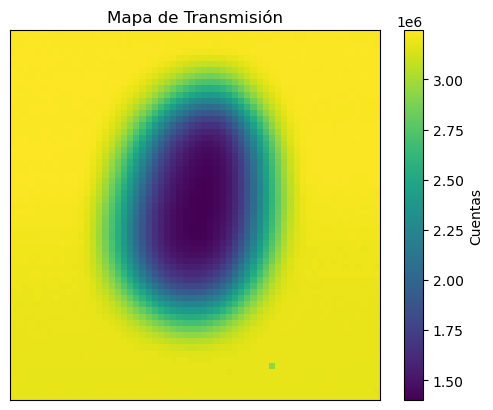

In [6]:
a = data.iloc[-1]
I = [a.iloc[i] for i in range(len(a))] 
I = np.array(I)
plt.imshow(I, cmap =color)
plt.title('Mapa de Transmisión')
#plt.xlabel('X') 
#plt.ylabel('Z')
plt.xticks([])
plt.yticks([])
plt.colorbar(label='Cuentas')
plt.show()
plt.imsave('Mapa_de_Transmisión_Degr_jet.jpg', I, cmap='jet')

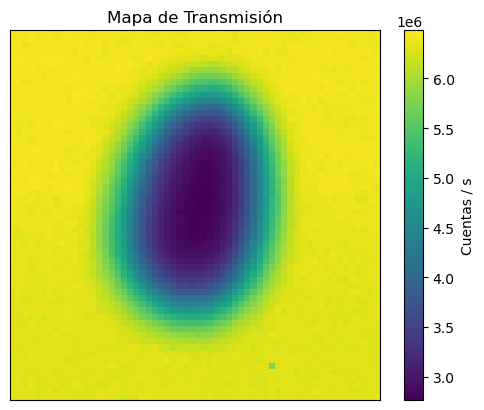

In [7]:
b = data.iloc[2]
T = [b.iloc[i] for i in range(len(b))] 
T = np.array(T)
G = I/T
plt.imshow(G, cmap=color)
plt.title('Mapa de Transmisión')
#plt.xlabel('X') 
#plt.ylabel('Z')
plt.colorbar(label="Cuentas / s")
plt.xticks([])
plt.yticks([])
plt.show()
plt.imsave('Mapa_de_Transmisión_Degr_jet.jpg', G, cmap='jet')

## 3.2 Haz Directo 

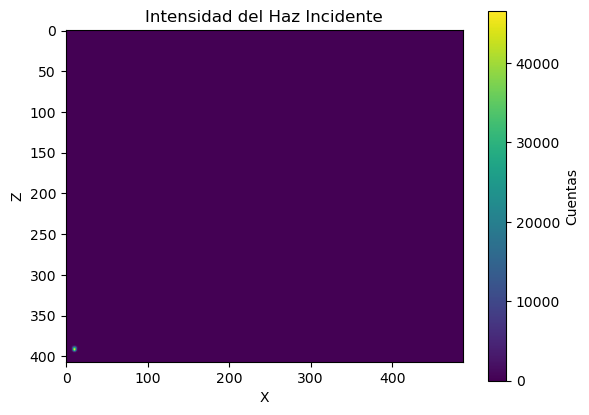

In [8]:
haz = fabio.open("Nahir_Vadra_20210413_0_00001.edf")
h = haz.data
plt.imshow(h, cmap=color)
plt.title('Intensidad del Haz Incidente')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label='Cuentas')
plt.show()

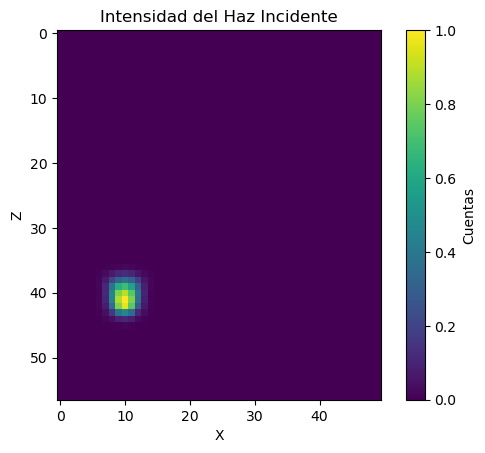

In [9]:
h1= h[350:,0:50]
h1 = h1/(np.amax(h1)) #normalización de la intensidad del haz
plt.imshow(h1, cmap=color)
plt.title('Intensidad del Haz Incidente')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label='Cuentas')
plt.show()

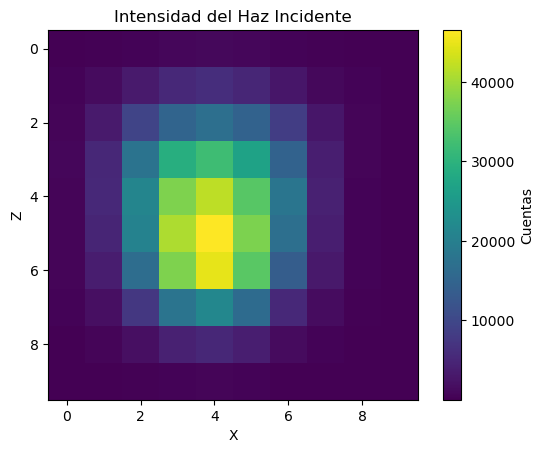

In [10]:
h1 = np.where(h1 > 0.01, h1, 0)
(i,j) = h1.shape
for m in range(i-1,-1,-1):
    for n in range(0,j):
        if h1[m,n] != 0:
            b = m
            break
for m in range(0,i):
    for n in range(0,j):
        if h1[m,n] != 0:
            c = m
            break
fl = (b,c)
for n in range(j-1,-1,-1):
    for m in range(0,i):
        if h1[m,n] != 0:
            d = n
            break
for n in range(0,j):
    for m in range(0,i):
        if h1[m,n] != 0:
            e = n
            break
cl = (d,e)
h1= h[350:,0:50]
#h1 = h1/(np.amax(h1))
h2 = h1[b:c+1,d:e+2]
np.save('h2.npy', h2)
#h2 = h2*np.amax(h1)
plt.imshow(h2, cmap = color)
plt.title('Intensidad del Haz Incidente')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label="Cuentas")
plt.show()

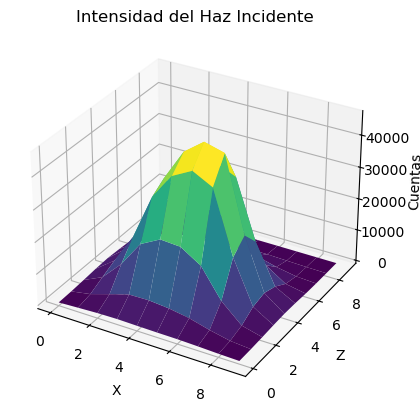

In [11]:
meshgrid = pd.DataFrame(h2)
x1 = np.linspace(1, 10, 10).astype(int)
x1 = x1-1
y1 = np.linspace(1, 10, 10).astype(int)
y1 = y1-1
X1, Y1 = np.meshgrid(x1, y1)
z1 = np.array([h2[i,j] for i,j in zip(np.ravel(X1), np.ravel(Y1))])
Z1 = z1.reshape(X1.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, Y1, Z1, cmap=color, edgecolor='none')
ax.set_title('Intensidad del Haz Incidente')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Cuentas')
plt.show()

## 3.3 Interpolación Haz Directo

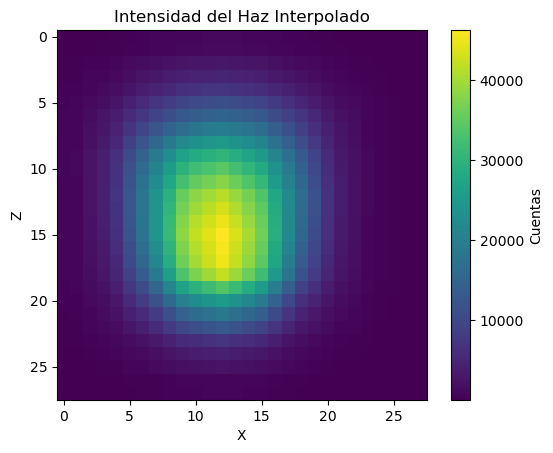

In [13]:
# Calcular el nuevo tamaño (misma lógica que tu función original)
new_shape = ((h2.shape[0]-1)*3 + 1, (h2.shape[1]-1)*3 + 1)

# Aplicar el resize directamente
h3 = resize(h2, new_shape, 
            order=1,          # Interpolación bilineal 
            mode='edge',      # Extensión de bordes 
            anti_aliasing=False)  # Desactivar para mantener comportamiento original

# Visualización
plt.imshow(h3, cmap=color)
plt.title('Intensidad del Haz Interpolado')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label="Cuentas")
plt.show()

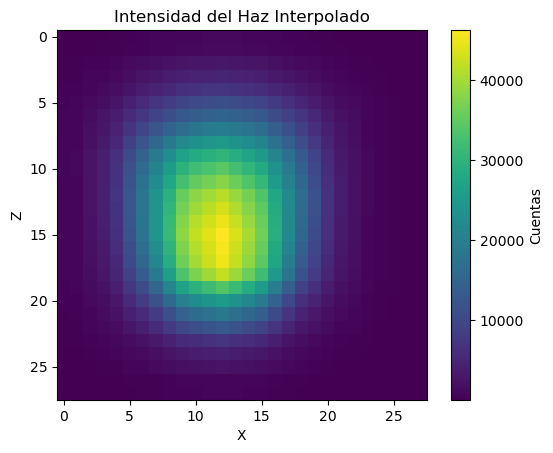

In [14]:
new_size = ((h2.shape[1]-1)*3 + 1, (h2.shape[0]-1)*3 + 1)

# Aplicar el resize directamente
h3_1 = cv2.resize(h2, new_size,
                interpolation=cv2.INTER_LINEAR)  # Bilineal como tu implementación

# Visualización
plt.imshow(h3, cmap=color)
plt.title('Intensidad del Haz Interpolado')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label="Cuentas")
plt.show()

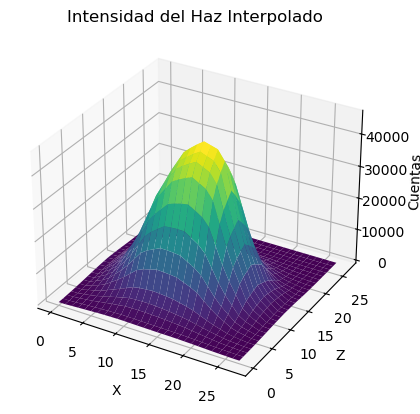

In [15]:
(k,l)=h3.shape
x2 = np.linspace(1, k, l).astype(int)
x2 = x2-1
y2 = np.linspace(1, k, l).astype(int)
y2 = y2-1
X2, Y2 = np.meshgrid(x2, y2)
z2 = np.array([h3[i,j] for i,j in zip(np.ravel(X2), np.ravel(Y2))])
Z2 = z2.reshape(X2.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X2, Y2, Z2,rstride=1, cstride=1, cmap=color, edgecolor='none')
ax.set_title('Intensidad del Haz Interpolado')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Cuentas')
plt.show()

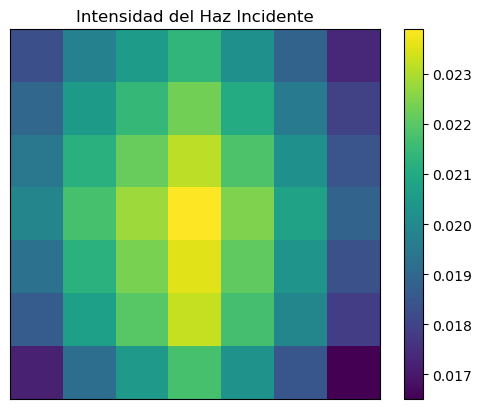

In [16]:
# i,j = np.where(h3 == np.amax(h3))
# h4=h3[i[0]-4:i[0]+5,j[0]-4:j[0]+5]
# h4=h4/np.amax(h3)
h4 = extraer_kernel(h3, 7)
plt.imshow(h4, cmap =color)
plt.title('Intensidad del Haz Incidente')
#plt.xlabel('X') 
#plt.ylabel('Z')
#plt.colorbar(label="Cuentas (%)")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()
#plt.imsave('Mapa_del_haz.jpg', h4, cmap='jet')

# 4. Procesamiento de los datos

## 4.1 Método 1

In [17]:
C = G[0:10,0:10]
mean1 = np.mean(C)

## 4.2 Método 2

In [18]:
q = G
ig = inverse_gaussian_gradient(G)
init_ls = np.zeros(ig.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1
evolution = []
callback = store_evolution_in(evolution)
seg = morphological_geodesic_active_contour(ig, 230, init_ls,
                                           smoothing=1, balloon=-1,
                                           threshold=0.69,
                                           iter_callback=callback)

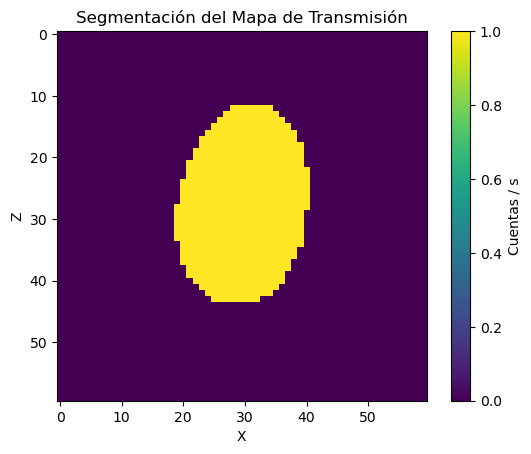

In [19]:
plt.imshow(seg, cmap = color)
plt.title('Segmentación del Mapa de Transmisión')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label="Cuentas / s")
plt.show()

In [20]:
(i,j) = seg.shape
f = []
for k in range(i):
    for l in range(j):
        if seg[k,l] == 1:
            f.append((k,l))

for i in range(len(f)):
    q[f[i]] = NA

In [21]:
o = pd.DataFrame(q)
o = o.dropna()
o = np.array(o)
mean2=np.mean(o)

In [22]:
print('Método 1: {0:.2f}, Método 2: {1:.2f}'.format(mean1,mean2))

Método 1: 6421143.28, Método 2: 6229732.18


## 4.3 Mapa de Absorción

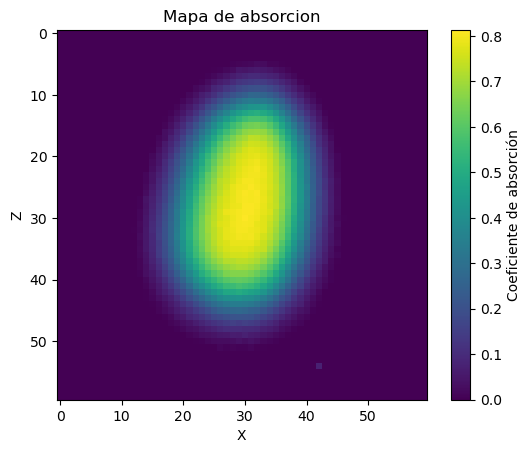

In [23]:
G = I/T
H = np.zeros(G.shape)
H = H+mean2
R1 = np.log(H/G)
R = np.where(R1 > 0, R1, 0)
plt.imshow(R, cmap = color)
plt.title('Mapa de absorcion')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label='Coeficiente de absorción')
plt.show()

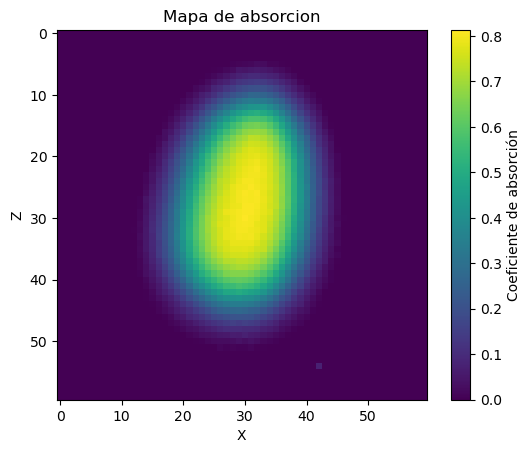

In [24]:
#R[R == 0] = np.min(R[R > 0])
plt.imshow(R, cmap = color)
plt.title('Mapa de absorcion')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label='Coeficiente de absorción')
plt.show()

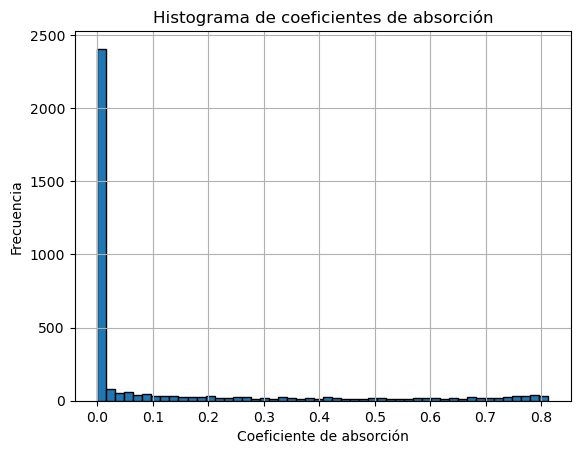

In [25]:
plt.figure()
plt.hist(R.flatten(), bins=50, edgecolor='black')
plt.title('Histograma de coeficientes de absorción')
plt.xlabel('Coeficiente de absorción')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [26]:
G.shape

(60, 60)

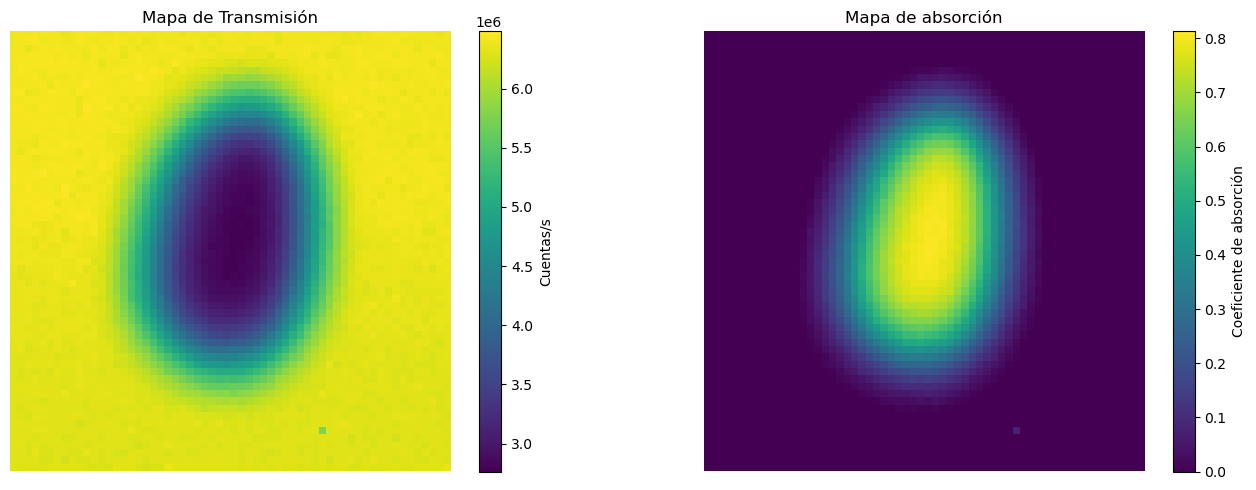

In [29]:
chia = mpimg.imread('Semilla_chia.png')

fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 fila, 3 columnas
#fig.suptitle('Mapas obtenidos',fontweight ="bold")

# Imagen 1: Muestra (RGB)
#axs[0].imshow(chia)
#axs[0].set_title('Muestra')
#axs[0].axis('off')
#axs[0].set_aspect('auto')

# Imagen 2: Mapa de transmisión con colorbar
im1 = axs[0].imshow(G, cmap=color)  # o cmap=color si ya lo definiste
axs[0].set_title('Mapa de Transmisión')
axs[0].axis('off')
#axs[0].set_aspect('auto')
fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04, label='Cuentas/s')

# Imagen 3: Mapa de absorción con colorbar
im2 = axs[1].imshow(R, cmap=color)  # o cmap=color
axs[1].set_title('Mapa de absorción')
axs[1].axis('off')
#axs[1].set_aspect('auto')
fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04, label='Coeficiente de absorción')

# Ajuste general
plt.savefig('mapas_saxs.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# 5. Deconvolución

## 5.1 Metodo Weiner

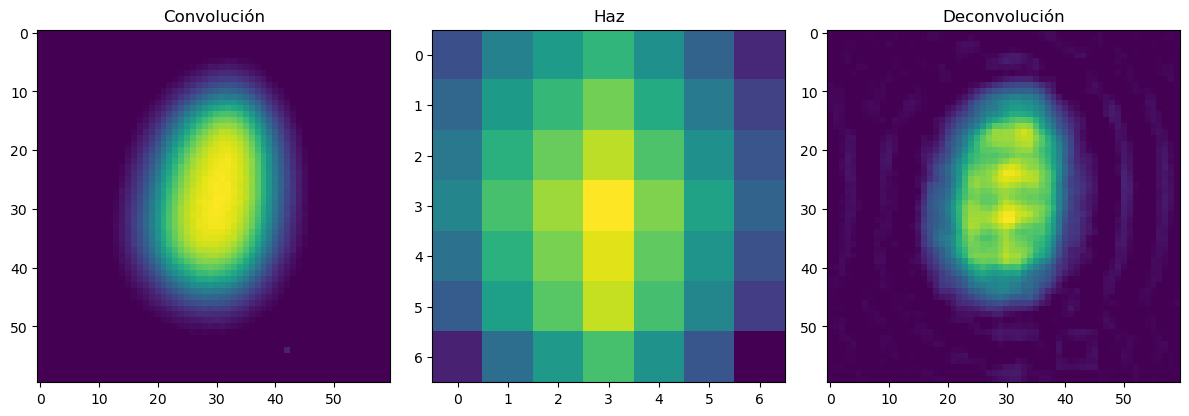

In [30]:
d, _ = unsupervised_wiener(R, h4)
d =  np.maximum(0,d)

fig, axes = plt.subplots(1, 3, figsize=(12, 8))
ax = axes.ravel()

ax[0].imshow(R, cmap = color)
ax[0].set_title("Convolución")
ax[1].imshow(h4, cmap = color)
ax[1].set_title('Haz')
ax[2].imshow(d, cmap = color)
ax[2].set_title('Deconvolución')

fig.tight_layout()
plt.show()

## 5.2 Método de Richarson-Lucy

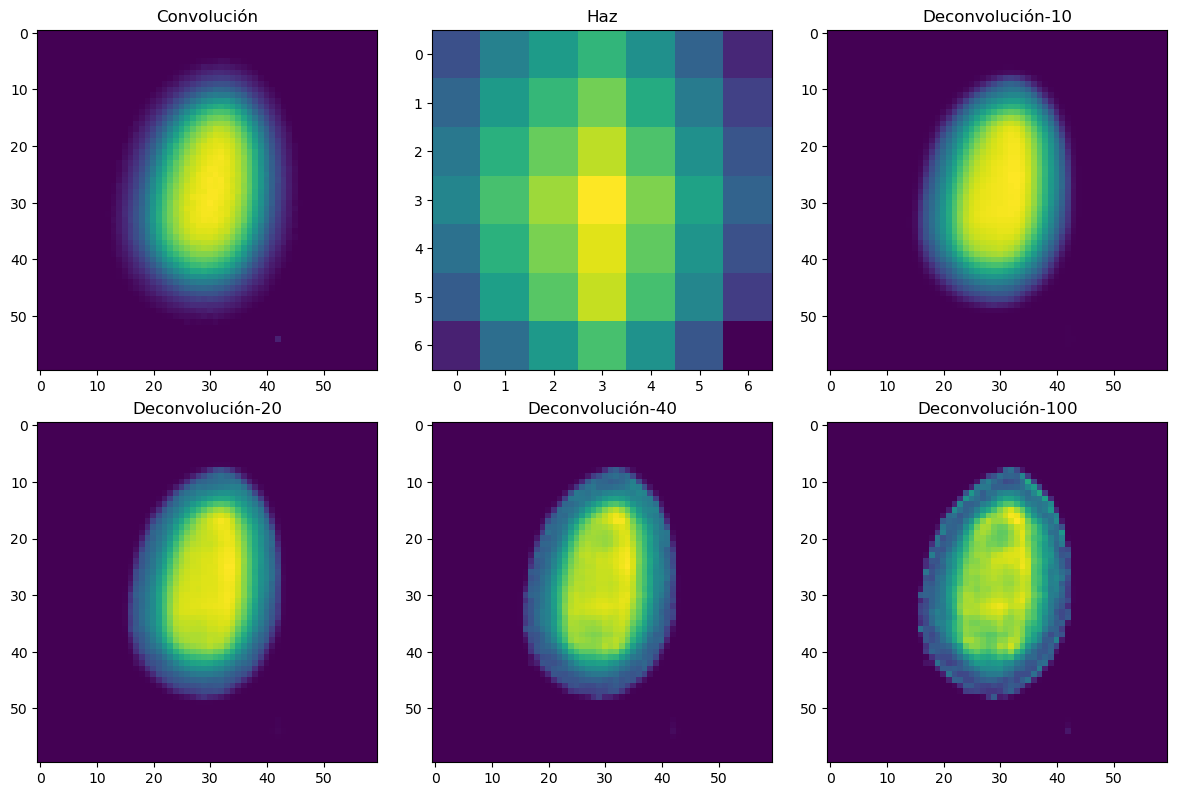

In [31]:
d1 = richardson_lucy(R, h4, num_iter=10, clip = False)
d2 = richardson_lucy(R, h4, num_iter=20, clip = False)
d3 = richardson_lucy(R, h4, num_iter=40, clip = False)
d4 = richardson_lucy(R, h4, num_iter=100, clip = False)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
ax = axes.ravel()

ax[0].imshow(R, cmap = color)
ax[0].set_title("Convolución")
ax[1].imshow(h4, cmap = color)
ax[1].set_title('Haz')
ax[2].imshow(d1, cmap = color)
ax[2].set_title('Deconvolución-10')
ax[3].imshow(d2, cmap = color)
ax[3].set_title('Deconvolución-20')
ax[4].imshow(d3, cmap = color)
ax[4].set_title('Deconvolución-40')
ax[5].imshow(d4, cmap = color)
ax[5].set_title('Deconvolución-100')

fig.tight_layout()
plt.show()

In [44]:
#fig, axes = plt.subplots(1, 2, figsize=(12, 8))
#camera = Camera(fig)

#axes[0].set_title("Original")
#axes[1].set_title(f'Restaurado')

#for i in range(1, 121, 1):
#    axes[0].imshow(R, cmap = color)
#    img = richardson_lucy(R, h4, num_iter=i, clip = False)
#    axes[1].imshow(img, cmap = color)
#    axes[1].text(10, 10, f'i = {i}', color='white', fontsize=12)
#    camera.snap()
#animation = camera.animate()

In [45]:
#animation.save('restauracion_RL.gif', fps = 10)

![Animación Restauración RL](restauracion_RL.gif)

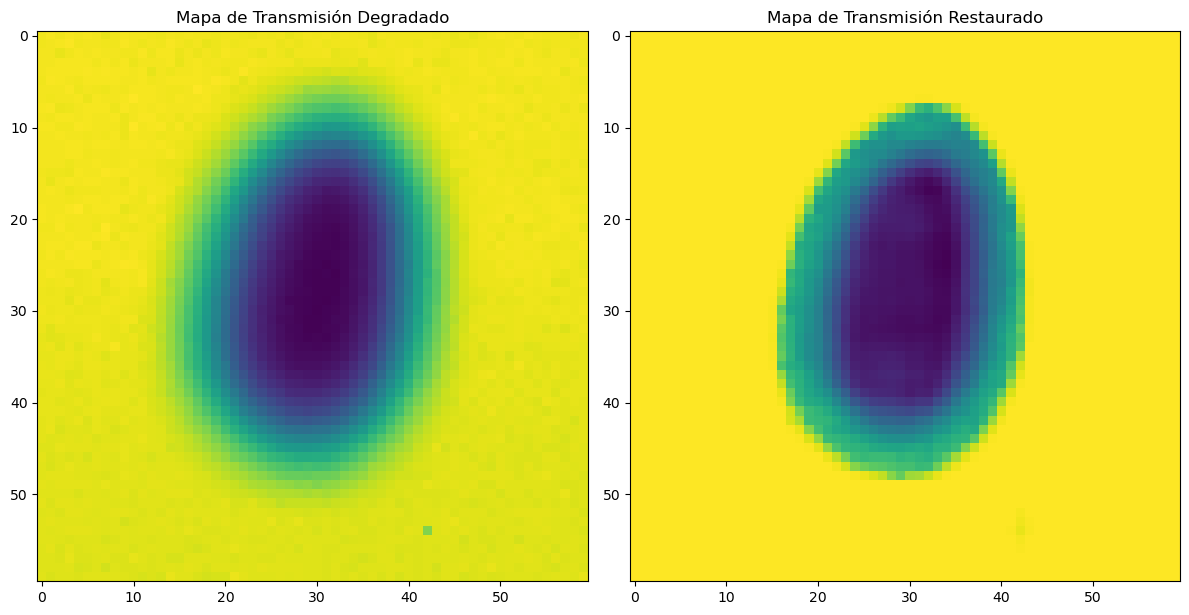

In [36]:
Td=H/np.exp(richardson_lucy(R, h4, num_iter=30, clip = False))

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
ax = axes.ravel()

ax[0].imshow(G, cmap = color)
ax[0].set_title("Mapa de Transmisión Degradado")
ax[1].imshow(Td, cmap = color)
ax[1].set_title('Mapa de Transmisión Restaurado')

plt.savefig('mapa_transmision_degradado_restaurado.png', dpi=300, bbox_inches='tight')
fig.tight_layout()
plt.show()

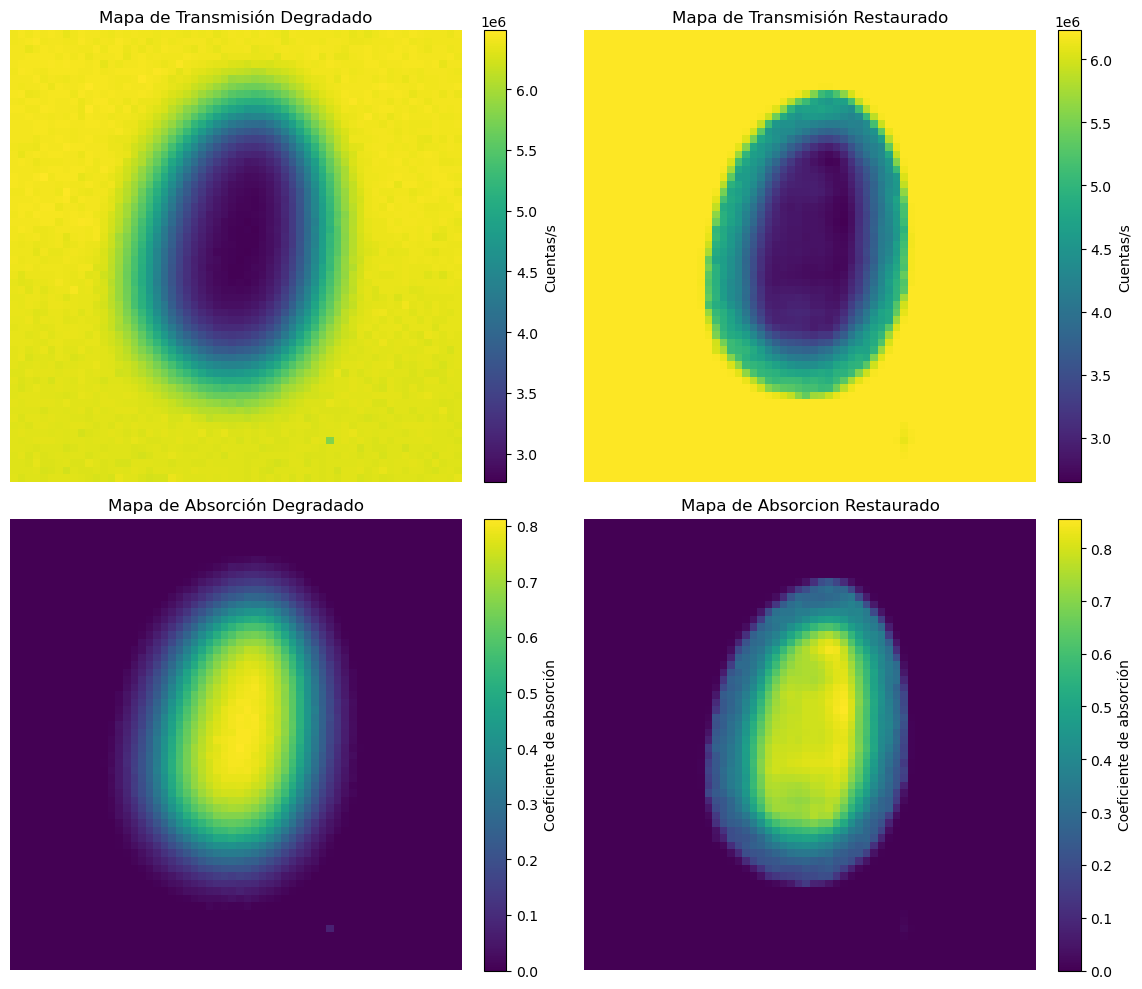

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # 1 fila, 3 columnas
#fig.suptitle('Mapas obtenidos',fontweight ="bold")

# Imagen 2: Mapa de transmisión con colorbar
im1 = axs[0, 0].imshow(G, cmap=color)  # o cmap=color si ya lo definiste
axs[0, 0].set_title('Mapa de Transmisión Degradado')
axs[0, 0].axis('off')
#axs[0].set_aspect('auto')
fig.colorbar(im1, ax=axs[0, 0], fraction=0.046, pad=0.04, label='Cuentas/s')

# Imagen 3: Mapa de absorción con colorbar
im2 = axs[0, 1].imshow(Td, cmap=color)  # o cmap=color
axs[0, 1].set_title('Mapa de Transmisión Restaurado')
axs[0, 1].axis('off')
#axs[1].set_aspect('auto')
fig.colorbar(im2, ax=axs[0, 1], fraction=0.046, pad=0.04, label='Cuentas/s')

# Imagen 2: Mapa de transmisión con colorbar
im3 = axs[1, 0].imshow(R, cmap=color)  # o cmap=color si ya lo definiste
axs[1, 0].set_title('Mapa de Absorción Degradado')
axs[1, 0].axis('off')
#axs[0].set_aspect('auto')
fig.colorbar(im3, ax=axs[1, 0], fraction=0.046, pad=0.04, label='Coeficiente de absorción')

# Imagen 3: Mapa de absorción con colorbar
im4 = axs[1, 1].imshow(richardson_lucy(R, h4, num_iter=30, clip = False), cmap=color)  # o cmap=color
axs[1, 1].set_title('Mapa de Absorcion Restaurado')
axs[1, 1].axis('off')
#axs[1].set_aspect('auto')
fig.colorbar(im4, ax=axs[1, 1], fraction=0.046, pad=0.04, label='Coeficiente de absorción')

# Ajuste general
plt.savefig('mapas_restaurados.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

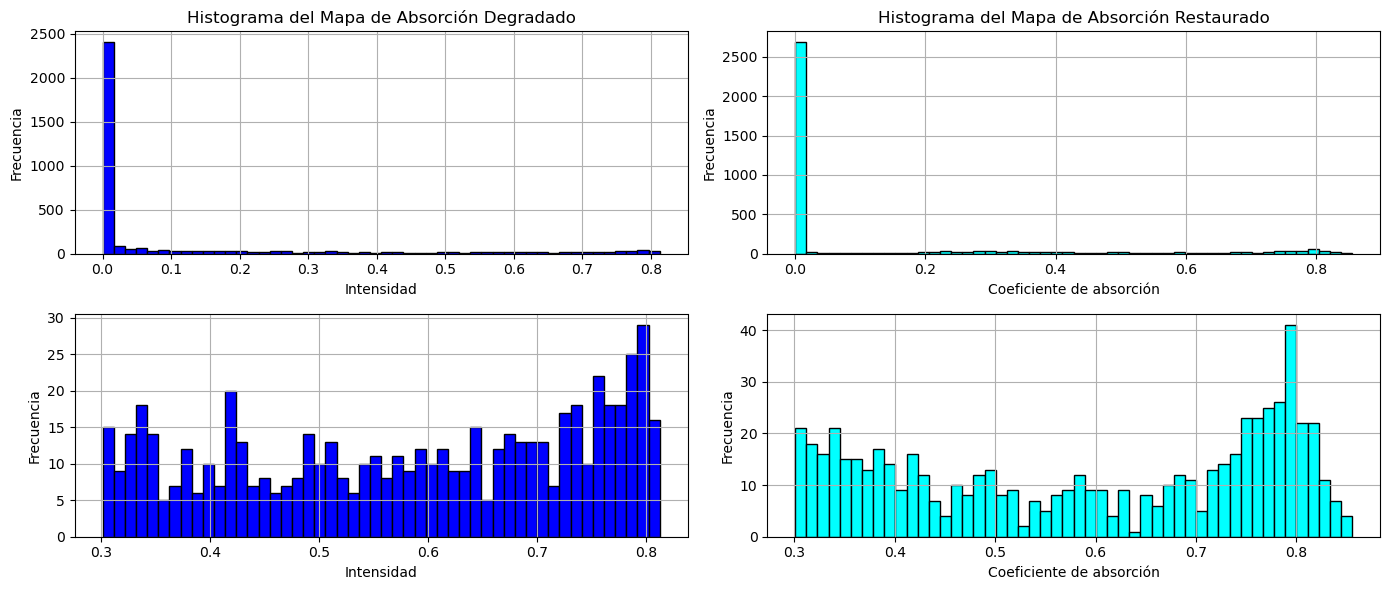

In [39]:
rest = richardson_lucy(R, h4, num_iter=30, clip = False)
fig, axs = plt.subplots(2, 2, figsize=(14, 6))

# Histograma de la imagen de transmisión (R1)
axs[0, 0].hist(R.flatten(), bins=50, color='blue', edgecolor='black')
axs[0, 0].set_title('Histograma del Mapa de Absorción Degradado')
axs[0, 0].set_xlabel('Intensidad')
axs[0, 0].set_ylabel('Frecuencia')
axs[0, 0].grid(True)

# Histograma de la imagen de absorción (R2)
axs[0, 1].hist(rest.flatten(), bins=50, color='cyan', edgecolor='black')
axs[0, 1].set_title('Histograma del Mapa de Absorción Restaurado')
axs[0, 1].set_xlabel('Coeficiente de absorción')
axs[0, 1].set_ylabel('Frecuencia')
axs[0, 1].grid(True)

# Histograma de la imagen de transmisión (R1)
axs[1, 0].hist(R[R>0.3].flatten(), bins=50, color='blue', edgecolor='black')
#axs[1, 0].set_title('Histograma del Mapa de Absorción Degradado')
axs[1, 0].set_xlabel('Intensidad')
axs[1, 0].set_ylabel('Frecuencia')
axs[1, 0].grid(True)

# Histograma de la imagen de absorción (R2)
axs[1, 1].hist(rest[rest>0.3].flatten(), bins=50, color='cyan', edgecolor='black')
#axs[1, 1].set_title('Histograma del Mapa de Absorción Restaurado')
axs[1, 1].set_xlabel('Coeficiente de absorción')
axs[1, 1].set_ylabel('Frecuencia')
axs[1, 1].grid(True)

plt.savefig('resultados_mapas_restaurados.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## 5.3 Método LIRA

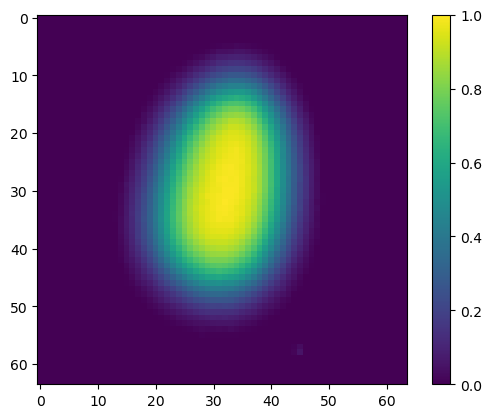

In [40]:
new_shape = (64, 64)
R_padded = resize(R, new_shape, 
            order=1,           # Interpolación bilineal (equivalente a tu implementación)
            mode='edge',       # Extensión de bordes similar a tu código
            anti_aliasing=False)  # Desactivar para mantener tu comportamiento original

R_1 = (R_padded/np.max(R_padded))
#R_1 = R_padded
plt.imshow(R_1, cmap = color)
plt.colorbar()
plt.show()

In [41]:
print(
    f"Ceros: {np.count_nonzero(R_1 == 0)}\n"
    f"Negativos: {np.count_nonzero(R_1 < 0)}\n"
    f"NaNs: {np.isnan(R_1).sum()}\n"
    f"Infinitos positivos: {np.isposinf(R_1).sum()}\n"
    f"Infinitos negativos: {np.isneginf(R_1).sum()}\n"
    f"Infinitos totales: {np.isinf(R_1).sum()}\n"
    f"No negativos: {np.count_nonzero(R_1 > 0)}"
)

Ceros: 2512
Negativos: 0
NaNs: 0
Infinitos positivos: 0
Infinitos negativos: 0
Infinitos totales: 0
No negativos: 1584


In [30]:
data1 = {
    'counts': R_1,          # Imagen observada (float32)
    'psf': h4,  # PSF normalizada
    'background': np.zeros_like(R_1),  # Fondo desconocido = 0
    'exposure': np.ones_like(R_1),     # Exposición uniforme
    'flux_init': R_1.copy()  # ¡Clave correcta es flux_init!
}

In [31]:
np.sum(h4)

np.float32(0.99999994)

In [32]:
%%time
deconvolve = LIRADeconvolver(
   alpha_init = 1*np.ones(np.log2(data1['counts'].shape[0]).astype(int)),
    n_iter_max = 2000,
    n_burn_in = 400,
    fit_background_scale=False,
)
result = deconvolve.run(data=data1)

CPU times: user 11.7 s, sys: 430 ms, total: 12.1 s
Wall time: 12.1 s


/home/gustavoq14/pylira310_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


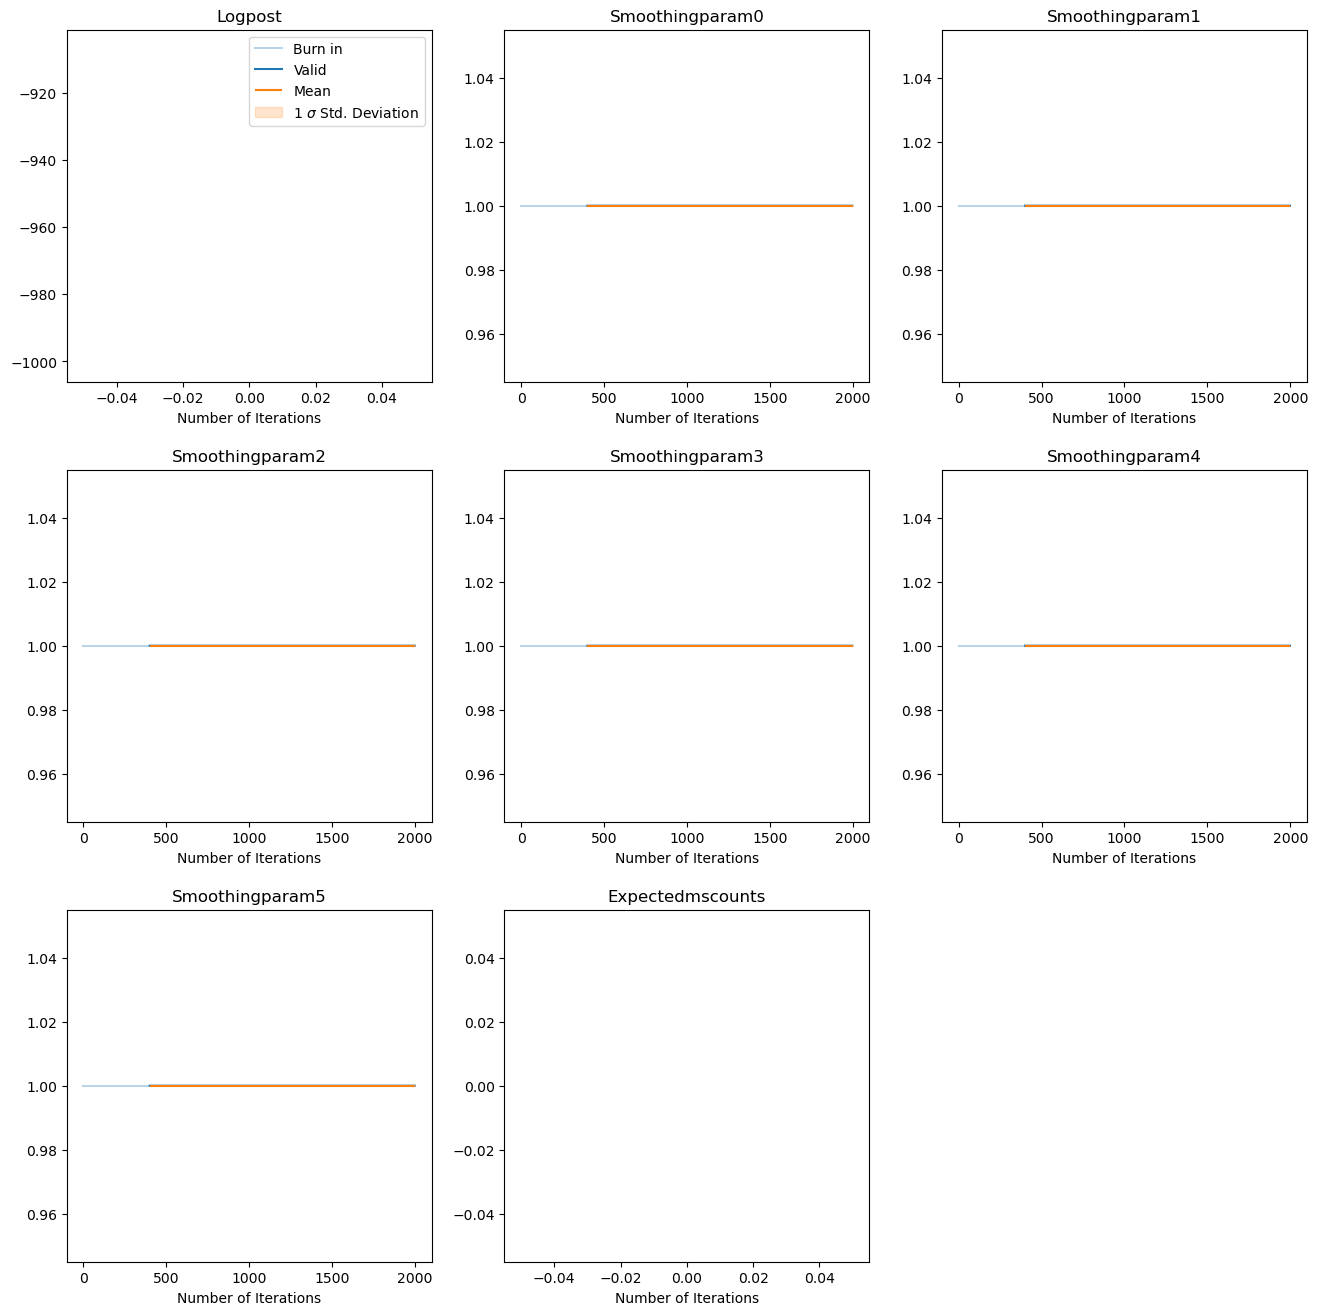

In [33]:
result.plot_parameter_traces()

/home/gustavoq14/pylira310_env/lib/python3.10/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/gustavoq14/pylira310_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3858: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/gustavoq14/pylira310_env/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/gustavoq14/pylira310_env/lib/python3.10/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/gustavoq14/pylira310_env/lib/python3.10/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/gustavoq14/pylira310_env/lib/python3.10/site-pac

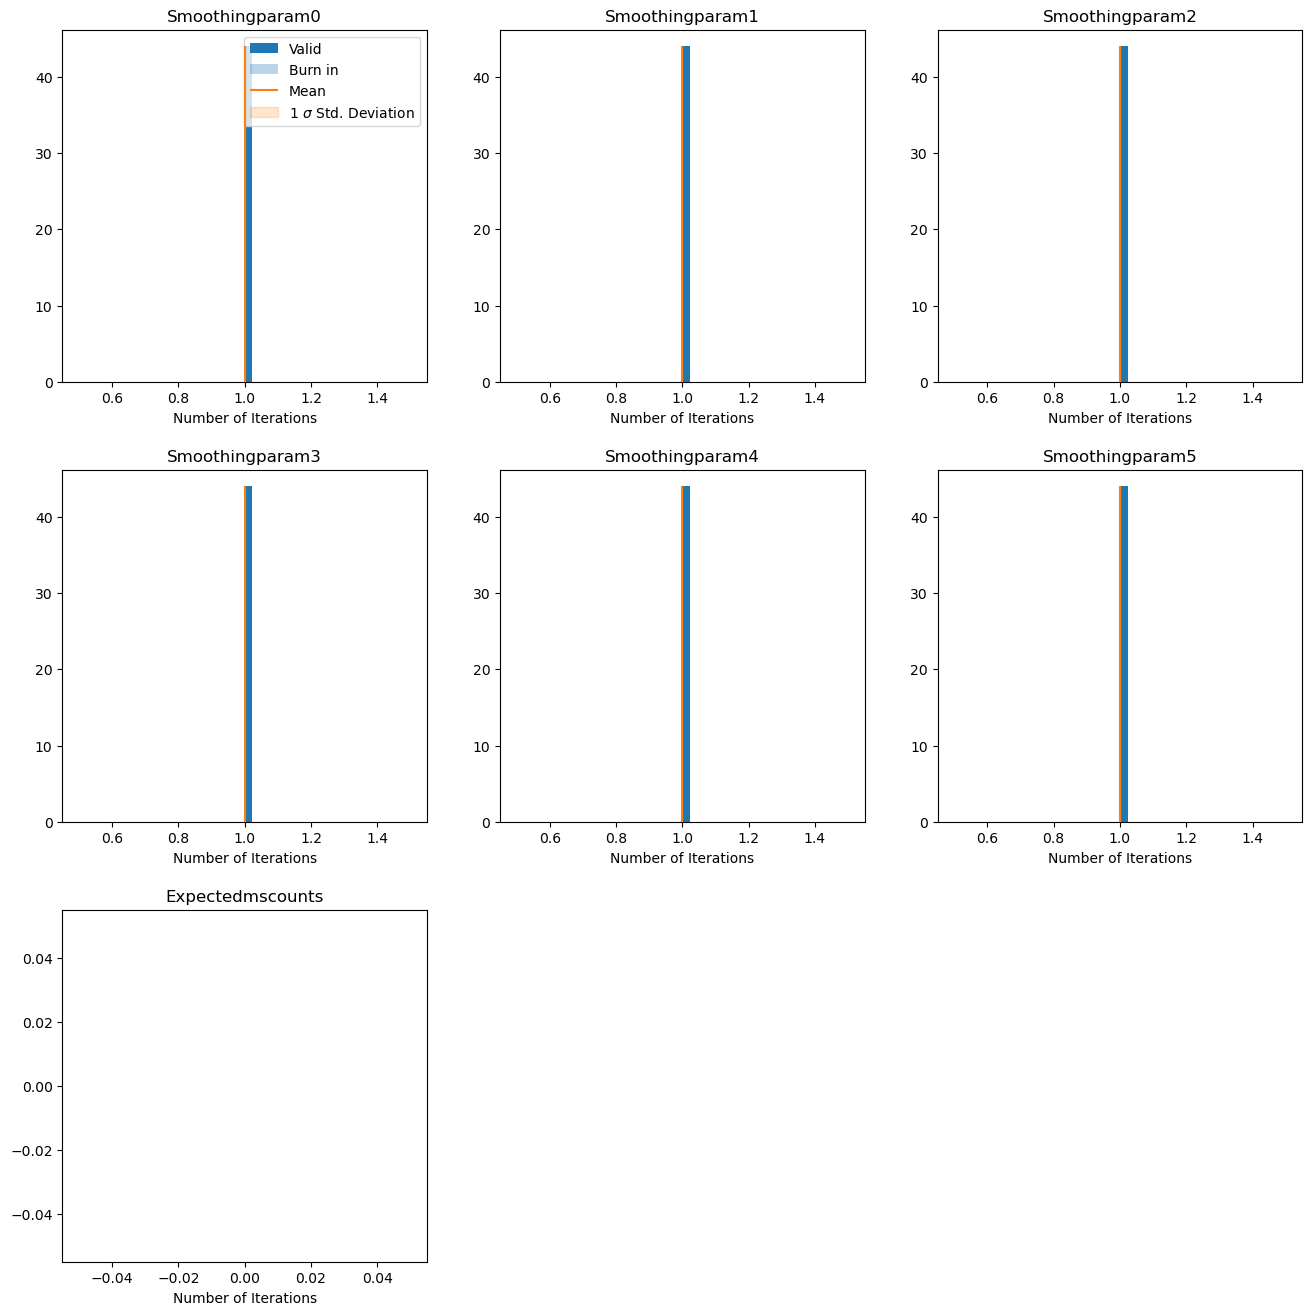

In [34]:
result.plot_parameter_distributions()